# IMPORT

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import sys
import os
# Add the root directory to the path
sys.path.append(os.path.abspath(".."))
from utils.classification_pipeline import create_classification_pipeline
from utils.clustering_pipeline import create_clustering_pipeline
from utils.custom_transformers import TargetTransformer
from utils.preprocessing_pipeline import create_preprocessing_pipeline

In [2]:
df = pd.read_csv("../data/data.csv", delimiter=",")
df

,id,gender,customer_senior,customer_partner,dependent_family,month_tenure,phone_subscription,multiple_line,internet_type,online_security,...,device_protection_plan,techinal_support,streaming_tv,streaming_movie,contract_type,paperless_billing,payment_method_type,amount_charges_monthly,amount_total_charges,churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


# PIPELINE

In [3]:
# Create preprocessing pipeline
preprocessing_pipeline = create_preprocessing_pipeline(df)

# Create clustering pipeline
clustering_pipeline = create_clustering_pipeline(preprocessing_pipeline, n_clusters=3)

# Create target transformer
target_transformer = TargetTransformer(column='churn')

# Create classification pipeline
classification_pipeline = create_classification_pipeline(preprocessing_pipeline, target_transformer)

# MODEL - Logistic Regression

### Training

Preparing the dataset with the Pipeline

In [4]:
# Prepare data for clustering (excluding target variable)
X_clustering = df.drop(columns=['id', 'churn'])

# Fit clustering pipeline
clustering_pipeline.fit(X_clustering)

# Retrieve cluster labels
cluster_labels = clustering_pipeline.named_steps['clustering'].labels_

# Add cluster labels to the original dataframe
df_cluster = df.copy()
df_cluster['cluster'] = cluster_labels

# Prepare data for classification
X = df.drop(columns=['churn'])
y = df['churn']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Fit classification pipeline (excluding 'id' from features)
X_train_features = X_train.drop(columns=['id'])
classification_pipeline.fit(X_train_features, y_train)

y_test_transformed = classification_pipeline.target_transformer.transform(y_test)


# Predict on test set
X_test_features = X_test.drop(columns=['id'])
y_pred = classification_pipeline.predict(X_test_features)
y_proba = classification_pipeline.predict_proba(X_test_features)[:, -1].round(2)


### Results

Clusters

In [5]:
df_cluster[["id", "cluster"]]

,id,cluster
0,7590-VHVEG,1
1,5575-GNVDE,1
2,3668-QPYBK,1
3,7795-CFOCW,1
4,9237-HQITU,1
...,...,...
7038,6840-RESVB,0
7039,2234-XADUH,0
7040,4801-JZAZL,1
7041,8361-LTMKD,1


Predictions

In [6]:
# Map predictions to customer IDs
predictions = pd.DataFrame({
    'id': X_test['id'],
    'real_churn': y_test_transformed,
    'predicted_churn': y_pred,
    "proba_churn": y_proba
})
predictions

,id,real_churn,predicted_churn,proba_churn
437,4376-KFVRS,0.0,0.0,0.03
2280,2754-SDJRD,0.0,1.0,0.70
2235,9917-KWRBE,0.0,0.0,0.07
4460,0365-GXEZS,0.0,0.0,0.40
3761,9385-NXKDA,0.0,0.0,0.02
...,...,...,...,...
5143,5204-HMGYF,0.0,0.0,0.04
4439,9950-MTGYX,0.0,0.0,0.02
3857,3675-EQOZA,0.0,0.0,0.14
4758,3646-ITDGM,0.0,0.0,0.01


Feature importance in the model

In [7]:
import numpy as np
import pandas as pd

# Assuming `log_model` is your fitted logistic regression model
log_model = classification_pipeline.named_steps["logistic_regression"]
coefficients = log_model.coef_[0]
odds_ratios = np.exp(coefficients)  # Convert coefficients to odds ratios

# Access the preprocessing step
preprocessing = classification_pipeline.named_steps['preprocessing']

# Get feature names after preprocessing
feature_names = preprocessing.named_steps['preparation'].get_feature_names_out()


# Create a DataFrame to show feature names, coefficients, and odds ratios
feature_importance = pd.DataFrame({
    'Feature': feature_names,  # X being your feature DataFrame used in logistic regression
    'Coefficient': coefficients,
    'Odds Ratio': odds_ratios
}, index=None).sort_values(by='Odds Ratio', ascending=False)

feature_importance.round(3)

,Feature,Coefficient,Odds Ratio
4,multiple_line_No phone service,0.904,2.468
25,amount_charges_monthly,0.658,1.931
22,payment_method_type_Electronic check,0.387,1.473
6,internet_type_Fiber optic,0.376,1.457
20,paperless_billing_Yes,0.375,1.454
5,multiple_line_Yes,0.218,1.244
0,customer_senior_Yes,0.143,1.153
23,payment_method_type_Mailed check,0.107,1.113
17,streaming_movie_Yes,0.082,1.086
2,customer_partner_Yes,0.024,1.025


In [9]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=1, shared_yaxes=True)

# Random Forest
feature_importance_light = feature_importance[feature_importance["Coefficient"] > 0].copy().round(3)

fig.add_trace(go.Bar(x=feature_importance_light['Feature'], y=feature_importance_light['Coefficient']), row=1, col=1)


fig.update_xaxes(tickangle=45, title_text="Variable", row=1, col=1)

# Set theme, margin, and annotation in layout
fig.update_layout(
    title="Feature Importance on Churn",
    template="plotly_white",
    margin=dict(r=10, t=80, b=40, l=40),
    showlegend=False
)

fig.show()

### Performance

In [7]:
from sklearn.metrics import classification_report

print(classification_report(y_test_transformed, y_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.89      0.87      1035
         1.0       0.64      0.54      0.59       374

    accuracy                           0.80      1409
   macro avg       0.74      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409



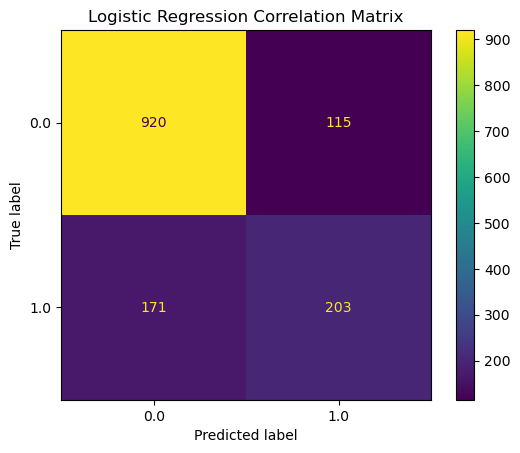

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt 

confusion_matrix_xgb=confusion_matrix(y_test_transformed, y_pred)
classes = log_model.classes_

disp_xgb = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_xgb, display_labels=classes)
disp_xgb.plot()

plt.title('Logistic Regression Correlation Matrix')
plt.show()